# LinkedIn Password Leak

The dataset used in this notebook can be found [here](https://figshare.com/articles/dataset/linkedin_files_zip/7350287).

In [101]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib

from pathlib import Path

%matplotlib inline

DATA_DIR = Path("../data/linkedin_dataset_v2_2019_04_01")

## How many unique leaked passwords are included in this dataset?

Count all the unique password ids in the full.out file

Using the shell

In [26]:
!cut {DATA_DIR}/full.out -d ' ' -f 1 | sort -n | uniq | wc -l

3639


Count all the password ids in the full.out file

Using python

In [27]:
with open(DATA_DIR/"full.out", "r") as full:
    print(len(full.readlines()))

3639


Using the shell

In [28]:
# What if we don't "unique" the data?
!wc -l {DATA_DIR}/full.out | cut -d ' ' -f 1

3639


Do we get the name number if we merge all the separate files and count the number of lines?

In [29]:
# It appears not, which suggests the presence of duplicate password ids across files
!ls {DATA_DIR} | grep -v full.out | xargs -I file cat {DATA_DIR}/file | cut -d ' ' -f 1 | wc -l

10504


In [30]:
# What if we only count the unique password ids?
!ls {DATA_DIR} | grep -v full.out | xargs -I file cat {DATA_DIR}/file | cut -d ' ' -f 1 | sort -n | uniq | wc -l 

3907


We still overshoot the count on full.out

I think we should not be attempting to merge (UNION DISTINCT) the files in this dataset
because the password ids (first column of each file) are only unique
within each file.

In [181]:
# The outputs of the following two commands confirm this theory
# !cat {DATA_DIR}/length10.out | cut -d ' ' -f 1 | sort -n
# !cat {DATA_DIR}/length11.out | cut -d ' ' -f 1 | sort -n

The question remains. What does full.out contain if not the entire contents of the partitioned data?

## How many passwords were leaked?

We aren't able to tell from the data how many accounts had their passwords leaked, or if between 2018 and 2019 any leaked passwords were from the same account.

Using the shell

In [35]:
!awk -F ' ' '{{s+=$$2}} END {{printf "%0.f", s}}' {DATA_DIR}/full.out

57431283

Using pandas

In [36]:
df = pd.read_csv(DATA_DIR/"full.out", delimiter=' ', header=None)

In [38]:
# rename columns
df.columns = ["password_id", "frequency"]

In [39]:
df.head()

,password_id,frequency
0,1135934,1
1,207490,1
2,188386,1
3,149910,1
4,110364,1


In [40]:
# ~57.431 million
full_sum = df["frequency"].sum()
full_sum

57431283

In [41]:
# According to all other files in the dataset
# Shows ~5.431 million
merged_ds_shell_sum = !ls {DATA_DIR} | grep -v full.out | xargs -I file cat {DATA_DIR}/file | awk -F ' ' '{{ s+=$$2}} END {{ printf "%0.f", s }}'

merged_ds_shell_sum = int(merged_ds_shell_sum[0])
merged_ds_shell_sum

57431558

In [42]:
# The frequencies match roughly. The differ by a count of 275, which is tiny in the grand scheme of things
abs(merged_ds_shell_sum - full_sum)

275

With the frequencies between full and the partitioned data set matching, I remain curious about the difference in the count of unique password ids in full.out and the partitioned dataset.

## Visualizing histogram of password length and number of passwords leaked

In [136]:
import glob


length_unique_pass_counts = {}
length_frequency = {}

for length_filepath in glob.glob(str(DATA_DIR/"l*.out")):
    filename = length_filepath.split("/")[-1]
    length = int(filename.split(".")[0].split("length")[1])
    
    with open(length_filepath) as f:
        lines = list(map(str.strip, f.readlines()))
        
        length_unique_pass_counts[length] = len(lines)
        
        total_frequency = 0
        for line in lines:
            password_id, frequency = map(str.strip, line.split(" "))
            total_frequency += int(frequency)
        
        length_frequency[length] = total_frequency
        
        
# print(length_unique_pass_counts)
# print(length_frequency)

In [162]:
sns.set(rc={"figure.figsize":(16, 12)})

### Plotting frequencies by password length

In [169]:
fbl_x = sorted(length_frequency.keys())
fbl_y = list(map(lambda pair: pair[1] / 1_000_000, sorted(length_frequency.items(), key=lambda pair: pair[0])))

# print(fbl_x)
# print(fbl_y)

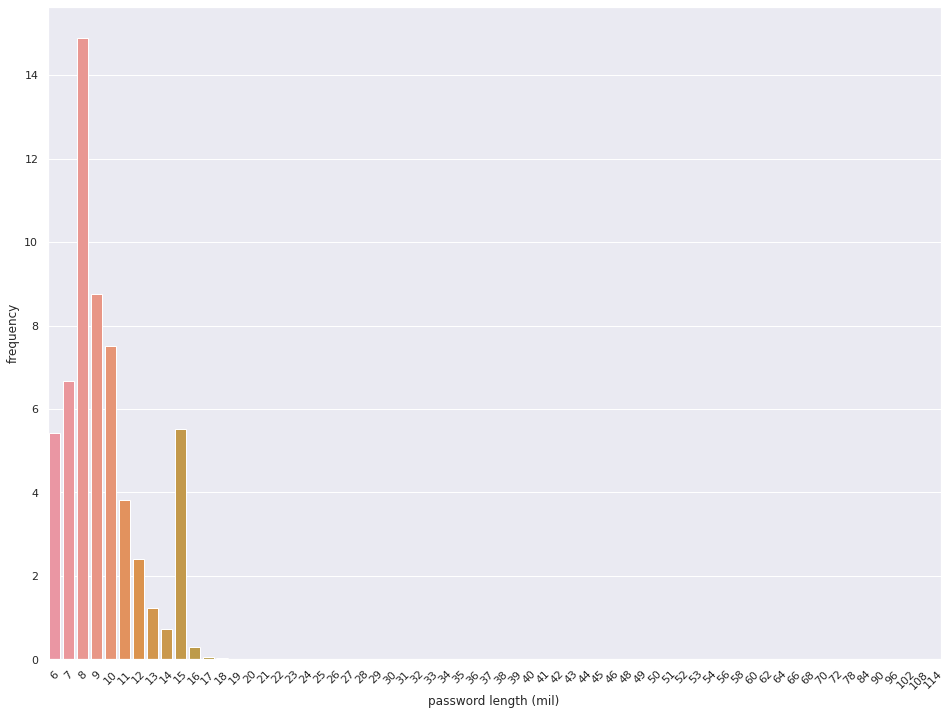

In [170]:
fbl = sns.barplot(x="password length (mil)",
                  y="frequency",
                  data=pd.DataFrame({"password length (mil)": fbl_x, "frequency": fbl_y}))

fbl.set_xticklabels(fbl.get_xticklabels(), rotation=45);

### Plotting line counts by password length

In [171]:
lcbl_x = sorted(length_unique_pass_counts.keys())
lcbl_y = list(map(lambda pair: pair[1], sorted(length_unique_pass_counts.items(), key=lambda pair: pair[0])))

# print(lcbl_x)
# print(lcbl_y)

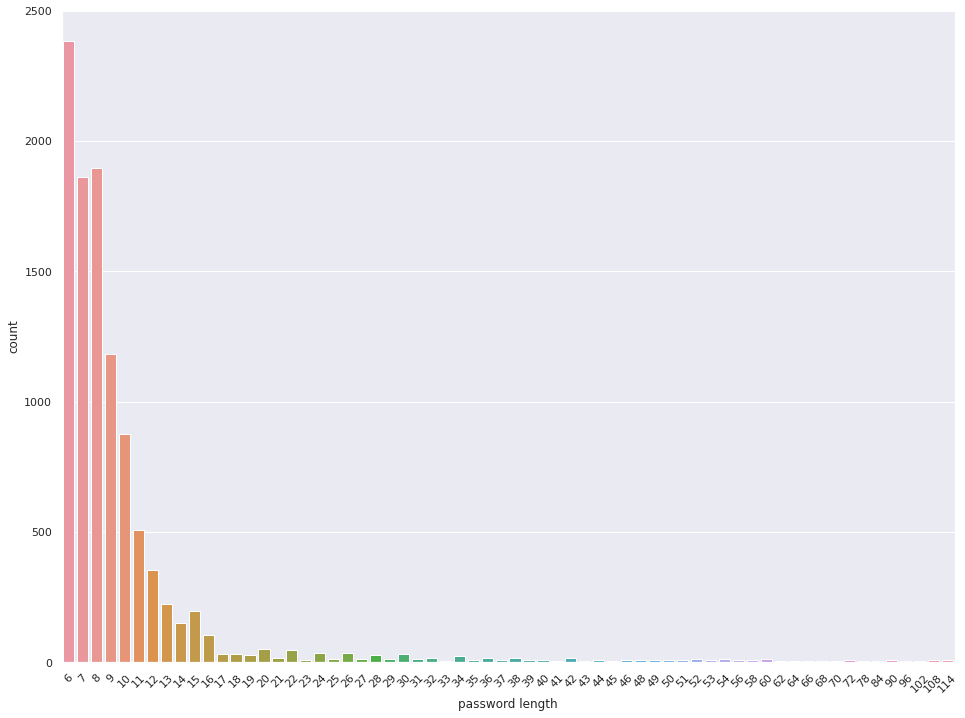

In [172]:
lcbl = sns.barplot(x="password length",
                   y="count",
                  data=pd.DataFrame({"password length": lcbl_x, "count": lcbl_y}))

lcbl.set_xticklabels(lcbl.get_xticklabels(), rotation=45);

The visualized data clearly confirms my expectation that most passwords are on the "short" end of the spectrum.

After all, who doesn't like a short, memorable password? :D

# Conclusion

This dataset was sparse in information. I didn't glean any new or interesting insight by exploring and analyzing the data. Furthermore, the data quality is questionable given the discrepancy observed in the record counts between the full.out file and the merged partioned data.

The similarity between the total password frequency in full.out and the merged partitioned data is likely coincidental.